In [1]:
!pip install lightgbm --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Visual and display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)


In [4]:
###raw CSV files
demand = pd.read_csv('assessment_demand_data.csv')
tariff = pd.read_csv('assessment_tariff_data.csv')

print("Demand columns:", demand.columns.tolist())
print("Tariff columns:", tariff.columns.tolist())

demand.head()



Demand columns: ['period_starting', 'mean_demand_kw']
Tariff columns: ['period_starting', 'price_pence_per_kwh']


,period_starting,mean_demand_kw
0,2023-04-01 00:00:00,216.0
1,2023-04-01 00:30:00,225.0
2,2023-04-01 01:00:00,221.0
3,2023-04-01 01:30:00,207.0
4,2023-04-01 02:00:00,216.0


In [5]:
tariff.head()

,period_starting,price_pence_per_kwh
0,2023-10-01 00:00:00,21
1,2023-10-01 00:30:00,21
2,2023-10-01 01:00:00,21
3,2023-10-01 01:30:00,21
4,2023-10-01 02:00:00,21


In [6]:
demand = pd.read_csv(
    'assessment_demand_data.csv',
    parse_dates=['period_starting']
)

tariff = pd.read_csv(
    'assessment_tariff_data.csv',
    parse_dates=['period_starting']
)

# Rename to a standard column name for easier handling
demand = demand.rename(columns={'period_starting': 'timestamp', 'mean_demand_kw': 'kw'})
tariff = tariff.rename(columns={'period_starting': 'timestamp', 'price_pence_per_kwh': 'price_pence'})

# Set timestamp as index
demand = demand.set_index('timestamp').sort_index()
tariff = tariff.set_index('timestamp').sort_index()

demand.head(), tariff.head()


(                        kw
 timestamp                 
 2023-04-01 00:00:00  216.0
 2023-04-01 00:30:00  225.0
 2023-04-01 01:00:00  221.0
 2023-04-01 01:30:00  207.0
 2023-04-01 02:00:00  216.0,
                      price_pence
 timestamp                       
 2023-10-01 00:00:00           21
 2023-10-01 00:30:00           21
 2023-10-01 01:00:00           21
 2023-10-01 01:30:00           21
 2023-10-01 02:00:00           21)

In [7]:
print("Demand shape:", demand.shape)
print("Tariff shape:", tariff.shape)

print("\nDemand index range:", demand.index.min(), "→", demand.index.max())
print("Tariff index range:", tariff.index.min(), "→", tariff.index.max())

print("\nDemand head:")
display(demand.head())

print("\nTariff head:")
display(tariff.head())


Demand shape: (8784, 1)
Tariff shape: (48, 1)

Demand index range: 2023-04-01 00:00:00 → 2023-09-30 23:30:00
Tariff index range: 2023-10-01 00:00:00 → 2023-10-01 23:30:00

Demand head:


,kw
timestamp,
2023-04-01 00:00:00,216.0
2023-04-01 00:30:00,225.0
2023-04-01 01:00:00,221.0
2023-04-01 01:30:00,207.0
2023-04-01 02:00:00,216.0



Tariff head:


,price_pence
timestamp,
2023-10-01 00:00:00,21
2023-10-01 00:30:00,21
2023-10-01 01:00:00,21
2023-10-01 01:30:00,21
2023-10-01 02:00:00,21


In [8]:
#### Basic data checks (the brief says the data is already clean, but I still verify it quickly)

print("=== Missing values ===")
print("Demand:\n", demand.isna().sum())
print("\nTariff:\n", tariff.isna().sum())

print("\n=== Duplicate timestamps ===")
print("Demand:", demand.index.duplicated().sum(), "duplicates")
print("Tariff:", tariff.index.duplicated().sum(), "duplicates")

print("\n=== Time step consistency (demand) ===")
print(demand.index.to_series().diff().value_counts().head())


=== Missing values ===
Demand:
 kw    0
dtype: int64

Tariff:
 price_pence    0
dtype: int64

=== Duplicate timestamps ===
Demand: 0 duplicates
Tariff: 0 duplicates

=== Time step consistency (demand) ===
timestamp
0 days 00:30:00    8783
Name: count, dtype: int64


In [9]:
demand_eda = demand.copy()
demand_eda["hour"] = demand_eda.index.hour
demand_eda["dow"] = demand_eda.index.dayofweek   # 0=Mon
demand_eda["date"] = demand_eda.index.date

tariff_eda = tariff.copy()
tariff_eda["hour"] = tariff_eda.index.hour
tariff_eda["dow"] = tariff_eda.index.dayofweek

demand_eda.head()


,kw,hour,dow,date
timestamp,,,,
2023-04-01 00:00:00,216.0,0,5,2023-04-01
2023-04-01 00:30:00,225.0,0,5,2023-04-01
2023-04-01 01:00:00,221.0,1,5,2023-04-01
2023-04-01 01:30:00,207.0,1,5,2023-04-01
2023-04-01 02:00:00,216.0,2,5,2023-04-01


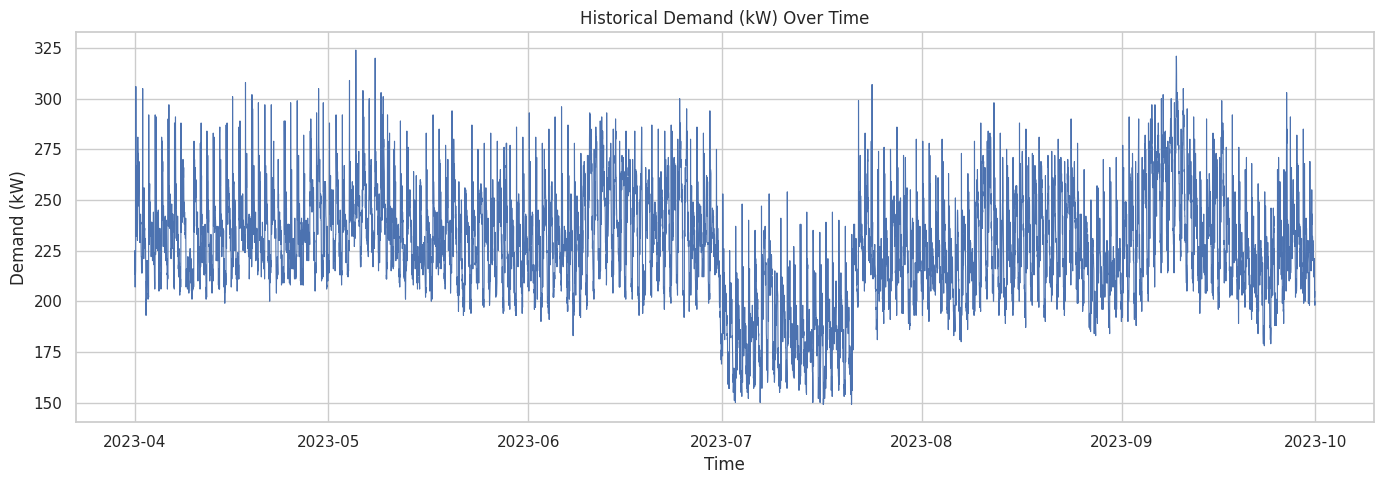

In [10]:
#### Plot the full historical demand time series
#### This helps get a first feel for daily/weekly patterns
####and any seasonal shifts over the months.
plt.figure(figsize=(14, 5))
plt.plot(demand_eda.index, demand_eda["kw"], linewidth=0.8)
plt.title("Historical Demand (kW) Over Time")
plt.xlabel("Time")
plt.ylabel("Demand (kW)")
plt.tight_layout()
plt.show()


**Quick interpretation:**  
The plot shows strong daily cycling in the site’s electricity usage, with regular peaks and troughs.  
There are also some longer-term changes through the year (e.g., slightly lower usage around mid-summer).  
This confirms that we should expect strong daily seasonality and some weekly patterns in the data.


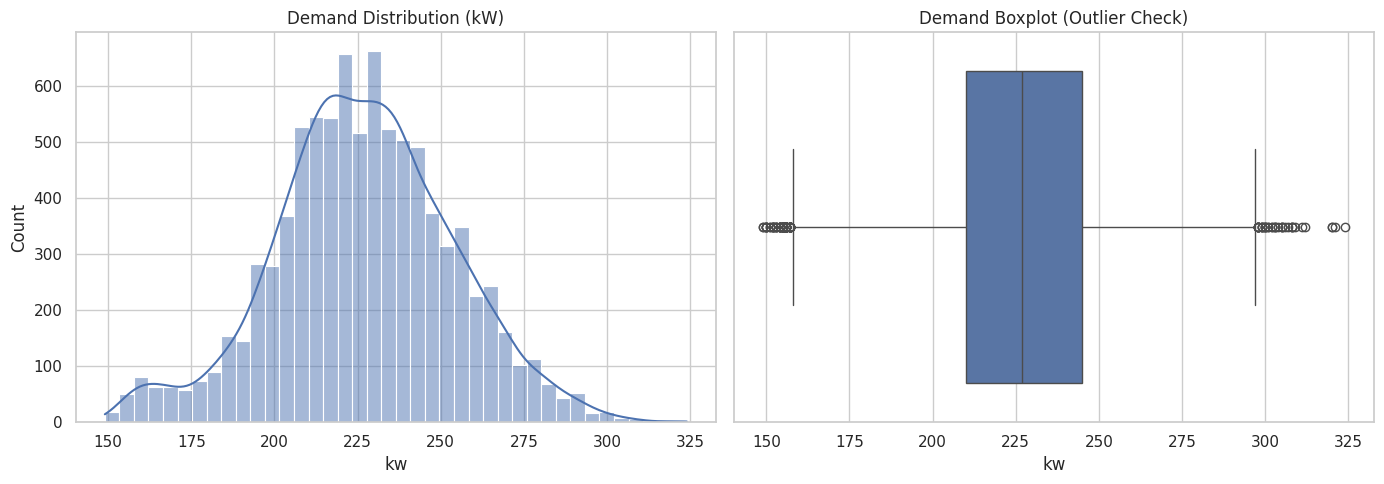

Demand summary stats:


,kw
count,8784.000000
mean,226.858151
std,27.032599
min,149.000000
25%,210.000000
50%,227.000000
75%,245.000000
max,324.000000


In [11]:
#### Look at the overall distribution of demand values.
#### The histogram shows how demand is spread across the year,
### and the boxplot helps highlight any potential outliers.
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

###Histogram with KDE (smooth curve)
sns.histplot(demand_eda["kw"], bins=40, kde=True, ax=axes[0])
axes[0].set_title("Demand Distribution (kW)")

###Boxplot for outlier inspection
sns.boxplot(x=demand_eda["kw"], ax=axes[1])
axes[1].set_title("Demand Boxplot (Outlier Check)")

plt.tight_layout()
plt.show()

### summary statistics for reference
print("Demand summary stats:")
display(demand_eda["kw"].describe())


**Quick gragh interpretation:**  
Most demand values sit between ~200–250 kW, with a fairly normal-looking distribution.  
There are a few higher and lower points, but nothing extreme — consistent with clean operational data.


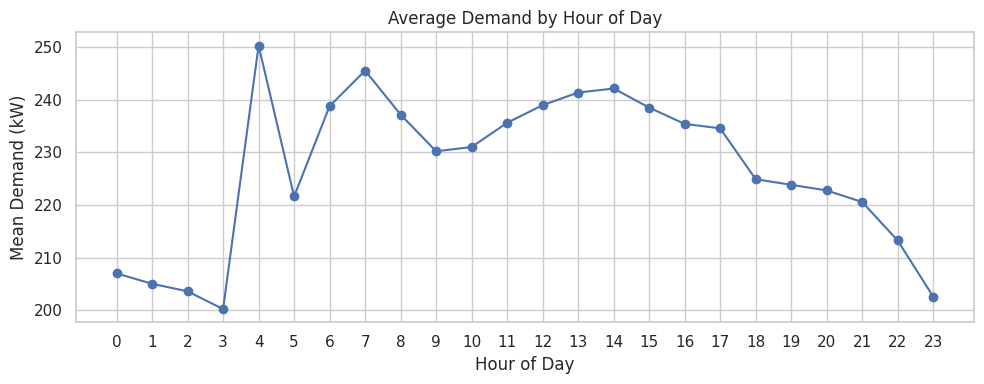

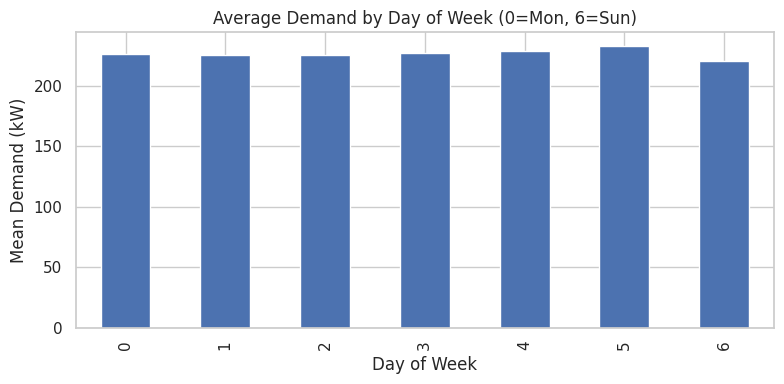

Average demand by hour:


,mean_kw
hour,
0,206.994536
1,205.030055
2,203.590164
3,200.224044
4,250.273224
5,221.603825
6,238.756831
7,245.513661
8,237.155738



Average demand by day of week:


,mean_kw
dow,
0,226.201923
1,226.071314
2,226.047276
3,227.257212
4,228.647436
5,232.846451
6,220.705128


In [12]:
## Look at how demand changes through the day.
##This highlights any typical daily pattern
## (e.g. morning/evening peaks).

# Average demand by hour of day
avg_by_hour = demand_eda.groupby("hour")["kw"].mean()

plt.figure(figsize=(10, 4))
avg_by_hour.plot(marker="o")
plt.title("Average Demand by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Demand (kW)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Now check if different days of the week behave differently.
# Useful for spotting weekday/weekend effects.


# Average demand by day of week
avg_by_dow = demand_eda.groupby("dow")["kw"].mean()

plt.figure(figsize=(8, 4))
avg_by_dow.plot(kind="bar")
plt.title("Average Demand by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Mean Demand (kW)")
plt.tight_layout()
plt.show()

print("Average demand by hour:")
display(avg_by_hour.to_frame("mean_kw"))

print("\nAverage demand by day of week:")
display(avg_by_dow.to_frame("mean_kw"))


**Quick graph interpreation:**  
The site shows a clear daily pattern — demand rises and falls at similar hours each day.  
There is also some variation across weekdays, which supports adding hour-of-day and day-of-week features.


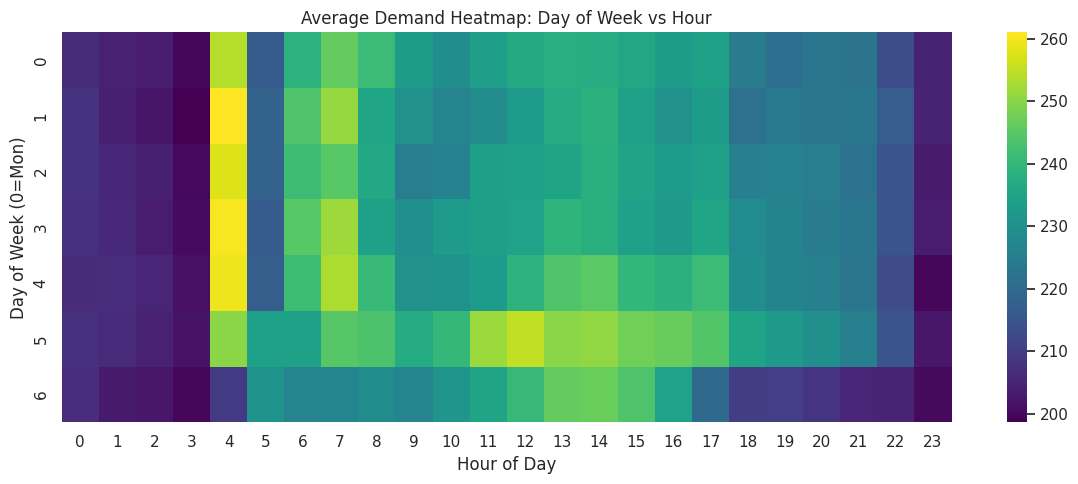

In [13]:
###Create a pivot table of average demand for each day-of-week
##× hour combination.
### This heatmap helps visualise how demand patterns vary across the week.

pivot_dow_hour = demand_eda.pivot_table(
    index="dow",
    columns="hour",
    values="kw",
    aggfunc="mean"
)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot_dow_hour, cmap="viridis")
plt.title("Average Demand Heatmap: Day of Week vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon)")
plt.tight_layout()
plt.show()


**Quick graph interpretation:**  
Daily patterns are very consistent across the week — early mornings are low, demand peaks around working hours, and evenings drop off.  
There are only small differences between weekdays and weekends, which matches the earlier plots.


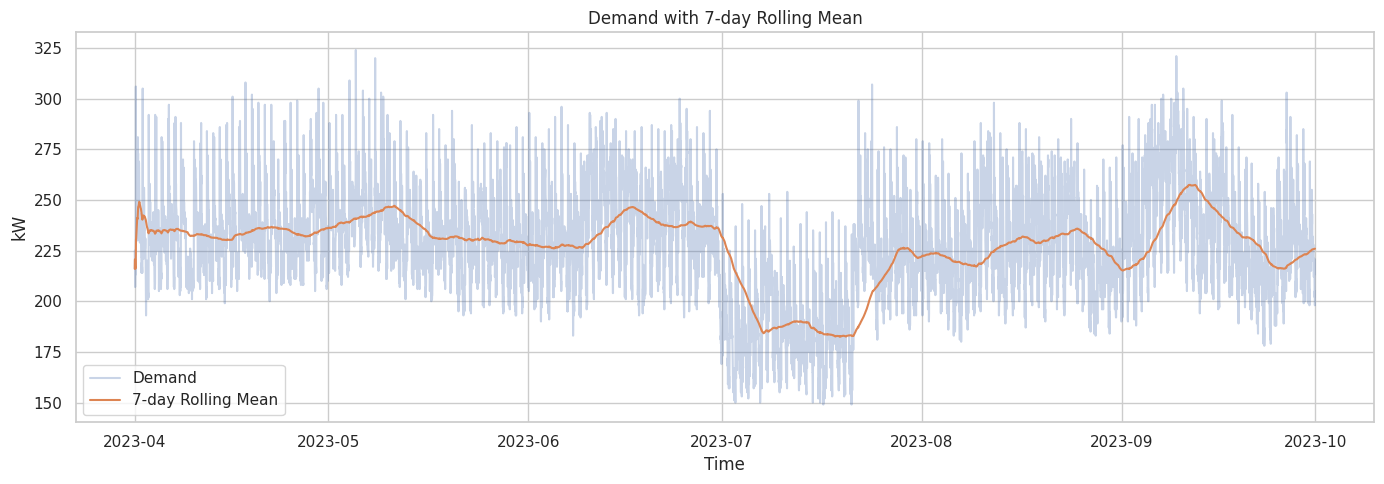

In [14]:
## Calculate a 7-day rolling mean and
## standard deviation to smooth out daily noise.
###This helps reveal any longer-term trends in the demand profile.
### 7-day window = 7 * 48 half-hours
window = 7 * 48

demand_eda["kw_rolling_mean_7d"] = demand_eda["kw"].rolling(window=window, min_periods=1).mean()
demand_eda["kw_rolling_std_7d"] = demand_eda["kw"].rolling(window=window, min_periods=1).std()

plt.figure(figsize=(14, 5))
plt.plot(demand_eda.index, demand_eda["kw"], alpha=0.3, label="Demand")
plt.plot(demand_eda.index, demand_eda["kw_rolling_mean_7d"], label="7-day Rolling Mean")
plt.title("Demand with 7-day Rolling Mean")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.tight_layout()
plt.show()


**interpretation of above graph:**  
The rolling mean smooths out the daily fluctuations and makes it easier to see slower changes over the months,  
such as the dip in mid-summer and the increase heading into autumn.


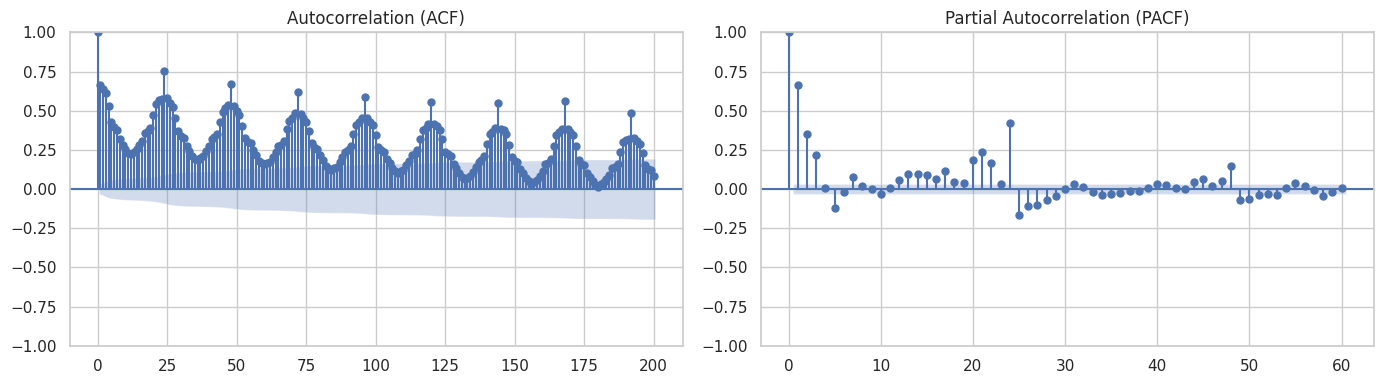

In [15]:
### Autocorrelation and partial autocorrelation help show how strongly
### the series depends on past values at different lags.
####I downsample slightly so the ACF plot is easier to read.

sample = demand_eda["kw"].iloc[::2]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(sample, lags=200, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(sample, lags=60, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()


**Quick interpretation of graphs:**  
Strong peaks around multiples of 48 lags confirm a clear daily pattern.  
This supports adding lag48, lag96, and other lag-based features later on.


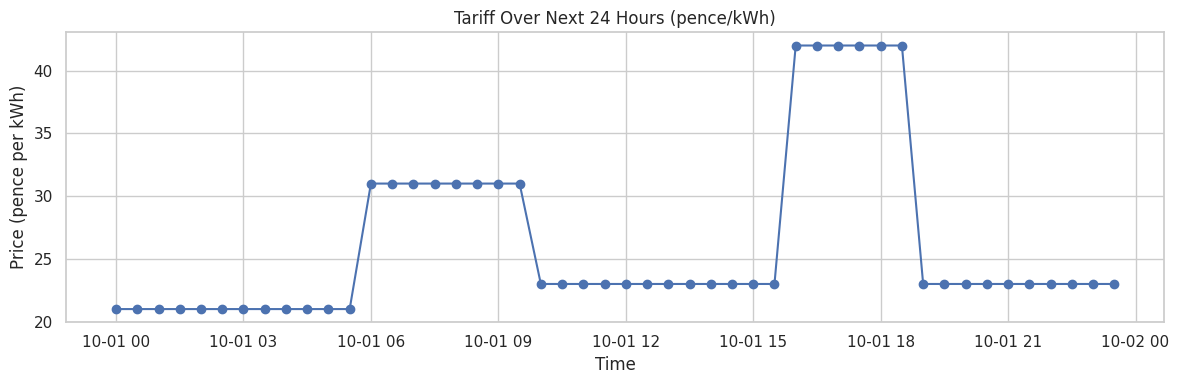

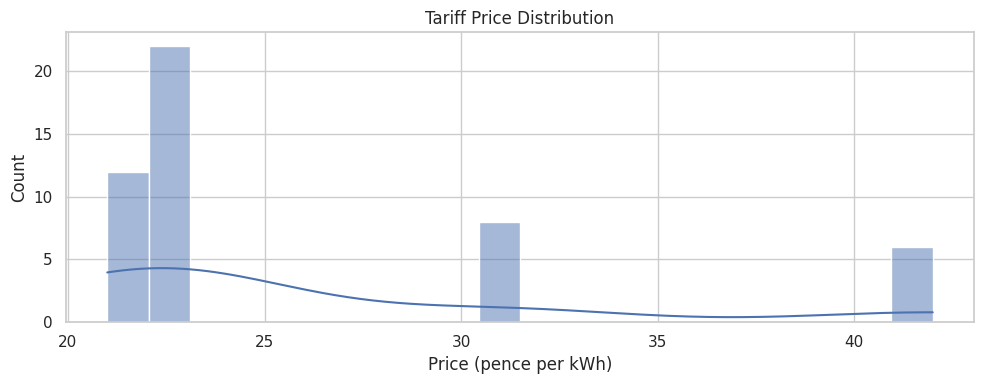

Cheapest 5 periods:


,price_pence
timestamp,
2023-10-01 00:00:00,21
2023-10-01 00:30:00,21
2023-10-01 01:00:00,21
2023-10-01 01:30:00,21
2023-10-01 02:00:00,21



Most expensive 5 periods:


,price_pence
timestamp,
2023-10-01 18:30:00,42
2023-10-01 16:30:00,42
2023-10-01 16:00:00,42
2023-10-01 17:00:00,42
2023-10-01 17:30:00,42



Tariff summary stats:


,price_pence
count,48.000000
mean,26.208333
std,6.891124
min,21.000000
25%,22.500000
50%,23.000000
75%,31.000000
max,42.000000


In [16]:
####Plot the tariff curve for the next 24 hours.
####This helps identify when electricity is cheapest or most expensive.

plt.figure(figsize=(12, 4))
plt.plot(tariff_eda.index, tariff_eda["price_pence"], marker="o")
plt.title("Tariff Over Next 24 Hours (pence/kWh)")
plt.xlabel("Time")
plt.ylabel("Price (pence per kWh)")
plt.tight_layout()
plt.show()

### Look at the distribution of
##prices to understand how variable the tariff is.
plt.figure(figsize=(10, 4))
sns.histplot(tariff_eda["price_pence"], bins=20, kde=True)
plt.title("Tariff Price Distribution")
plt.xlabel("Price (pence per kWh)")
plt.tight_layout()
plt.show()

### Sort the tariff to see the
###cheapest and most expensive periods clearly.
tariff_sorted = tariff_eda.sort_values("price_pence")
print("Cheapest 5 periods:")
display(tariff_sorted.head(5)[["price_pence"]])

print("\nMost expensive 5 periods:")
display(tariff_sorted.tail(5)[["price_pence"]])

print("\nTariff summary stats:")
display(tariff_eda["price_pence"].describe())


**interpretation:**  
The tariff is fairly stable but still varies enough to make battery arbitrage worthwhile.  
Identifying the cheapest and most expensive periods helps guide the charging/discharging strategy.


In [18]:
# Start modelling dataframe from demand
df = demand.copy()   # demand already has index=timestamp and column 'kw'

df.head()


,kw
timestamp,
2023-04-01 00:00:00,216.0
2023-04-01 00:30:00,225.0
2023-04-01 01:00:00,221.0
2023-04-01 01:30:00,207.0
2023-04-01 02:00:00,216.0


##Feature Engineering

In [19]:
#### Create basic lag features.
### These capture short-term behaviour (lag1)
### and the strong daily cycle (lag48, lag96, lag144).
df['lag1'] = df['kw'].shift(1)
df['lag48'] = df['kw'].shift(48)
df['lag96'] = df['kw'].shift(96)
df['lag144'] = df['kw'].shift(144)


In [20]:
# # Rolling means and stds
# df['roll_mean_6'] = df['kw'].rolling(6).mean()        # last 3 hours
# df['roll_mean_48'] = df['kw'].rolling(48).mean()      # last 24 hours
# df['roll_std_6'] = df['kw'].rolling(6).std()
# df['roll_std_48'] = df['kw'].rolling(48).std()

# # Time-based features from the index
# df['hour'] = df.index.hour
# df['dow'] = df.index.dayofweek
# df['is_weekend'] = (df['dow'] >= 5).astype(int)
# df['month'] = df.index.month

# # Cyclical encodings
# df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
# df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
# df['dow_sin']  = np.sin(2 * np.pi * df['dow'] / 7)
# df['dow_cos']  = np.cos(2 * np.pi * df['dow'] / 7)

# # Residual vs yesterday
# df['diff_48'] = df['kw'] - df['lag48']


In [ ]:
# Rolling statistics to capture short-term trends and variability
df['roll_mean_6'] = df['kw'].rolling(6).mean()         # average over the last 3 hours
df['roll_mean_48'] = df['kw'].rolling(48).mean()       # average over the last 24 hours
df['roll_std_6'] = df['kw'].rolling(6).std()
df['roll_std_48'] = df['kw'].rolling(48).std()

# Time-based features taken directly from the timestamp
df['hour'] = df.index.hour
df['dow'] = df.index.dayofweek
df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['month'] = df.index.month

# Cyclical encodings to represent hour/day smoothly (useful for models)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin']  = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos']  = np.cos(2 * np.pi * df['dow'] / 7)

# Difference from yesterday at the same time (helps capture short-term changes)
df['diff_48'] = df['kw'] - df['lag48']


**Notes:**  
These features capture short-term behaviour, daily patterns, and smooth time-of-day effects.  
They form the main input set for the forecasting model.


In [21]:
df_model = df.dropna().copy()
df_model.head()


,kw,lag1,lag48,lag96,lag144,roll_mean_6,roll_mean_48,roll_std_6,roll_std_48,hour,dow,is_weekend,month,hour_sin,hour_cos,dow_sin,dow_cos,diff_48
timestamp,,,,,,,,,,,,,,,,,,
2023-04-04 00:00:00,224.0,218.0,211.0,222.0,216.0,226.833333,231.895833,8.998148,16.750026,0,1,0,4,0.000000,1.000000,0.781831,0.62349,13.0
2023-04-04 00:30:00,224.0,224.0,209.0,222.0,225.0,223.500000,232.208333,3.209361,16.451034,0,1,0,4,0.000000,1.000000,0.781831,0.62349,15.0
2023-04-04 01:00:00,215.0,224.0,208.0,218.0,221.0,221.333333,232.354167,3.881580,16.261807,1,1,0,4,0.258819,0.965926,0.781831,0.62349,7.0
2023-04-04 01:30:00,210.0,215.0,201.0,214.0,207.0,219.000000,232.541667,5.727128,15.941326,1,1,0,4,0.258819,0.965926,0.781831,0.62349,9.0
2023-04-04 02:00:00,207.0,210.0,203.0,219.0,216.0,216.333333,232.625000,7.061633,15.793380,2,1,0,4,0.500000,0.866025,0.781831,0.62349,4.0


##Train/Test Split (last 48 periods = test)

In [22]:
# Forecast horizon = 48 half-hours (24 hours)
forecast_horizon = 48

train = df_model.iloc[:-forecast_horizon].copy()
test = df_model.iloc[-forecast_horizon:].copy()

X_train = train.drop(columns=['kw'])
y_train = train['kw']

X_test = test.drop(columns=['kw'])
y_test = test['kw']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (8592, 17)
Test shape: (48, 17)


In [23]:
### Train a LightGBM regression model on the historical features.
### These settings give a good balance between flexibility and stability.

from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 17
[LightGBM] [Info] Start training from score 226.741387


In [24]:
### Naive baseline: use yesterday's values (lag48) as the forecast.
### This gives a simple benchmark to compare the model against.
naive_preds = df_model['lag48'].iloc[-forecast_horizon:]


In [25]:
###Evaluate both the LightGBM model
###and the naive baseline using MAE and RMSE.

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

###LightGBM
mae_lgbm = mean_absolute_error(y_test, preds)
rmse_lgbm = rmse(y_test, preds)

### Naive (yesterday = today) performance
mae_naive = mean_absolute_error(y_test, naive_preds)
rmse_naive = rmse(y_test, naive_preds)

print("=== MODEL PERFORMANCE ===")
print(f"LightGBM MAE:  {mae_lgbm:.3f}")
print(f"LightGBM RMSE: {rmse_lgbm:.3f}")
print()
print("=== NAIVE BASELINE ===")
print(f"Naive MAE:     {mae_naive:.3f}")
print(f"Naive RMSE:    {rmse_naive:.3f}")


=== MODEL PERFORMANCE ===
LightGBM MAE:  1.144
LightGBM RMSE: 1.642

=== NAIVE BASELINE ===
Naive MAE:     13.229
Naive RMSE:    18.694


**Quick notes:**  
The ML model performs far better than the naive approach, showing it captures daily patterns and short-term behaviour much more accurately.


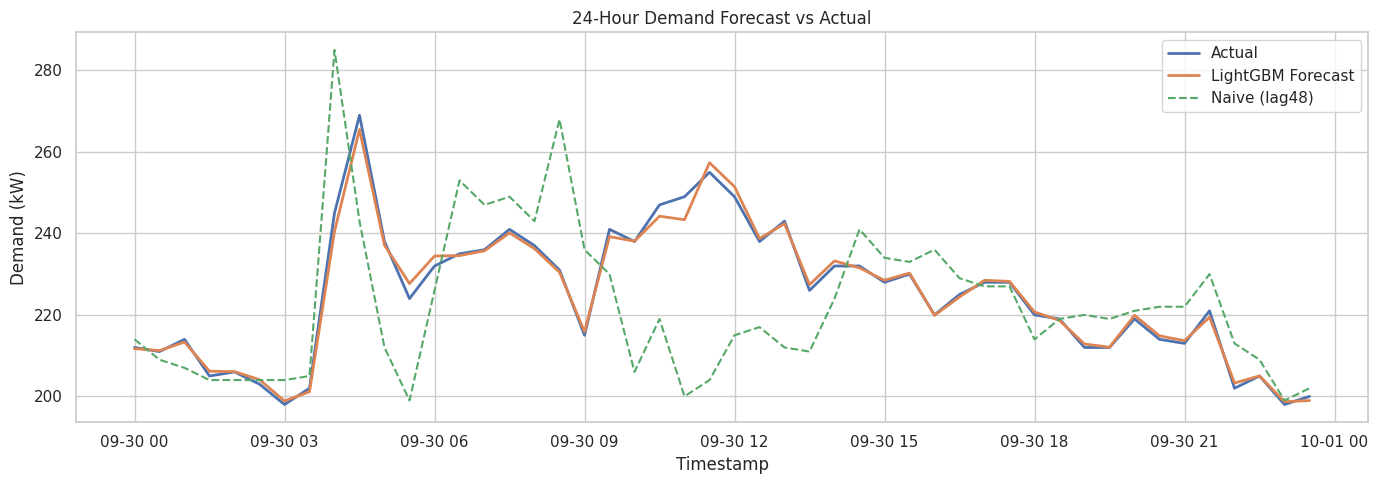

In [26]:
### Plot the actual demand alongside the LightGBM forecast
### and the naive baseline for the 24-hour test period.

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, preds, label="LightGBM Forecast", linewidth=2)
plt.plot(y_test.index, naive_preds, label="Naive (lag48)", linestyle="--")
plt.title("24-Hour Demand Forecast vs Actual")
plt.xlabel("Timestamp")
plt.ylabel("Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


**Quick gragh interpretation:**  
The LightGBM forecast tracks the real demand very closely, including the early-morning rise and later dips.  
The naive model misses these changes, which explains its much higher error.



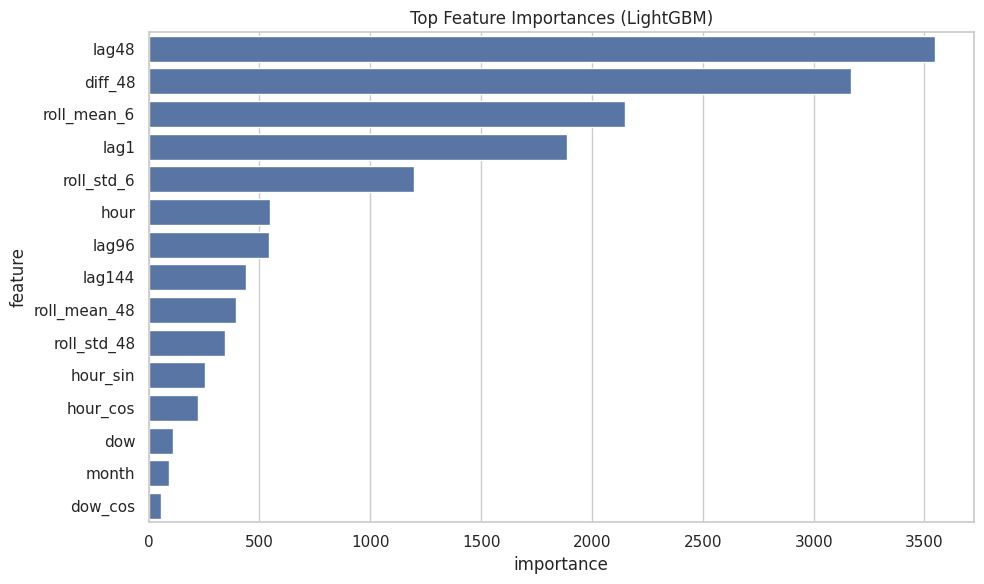

,feature,importance
1,lag48,3546
16,diff_48,3170
4,roll_mean_6,2147
0,lag1,1889
6,roll_std_6,1196
8,hour,548
2,lag96,542
3,lag144,438
5,roll_mean_48,393
7,roll_std_48,344


In [27]:
### Collect the feature importances from the trained LightGBM model
### and sort them from most to least important.

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importances.head(15), x='importance', y='feature')
plt.title("Top Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


### Display the top features as a table
importances.head(15)


**Quick interpretation:**  
The model relies heavily on daily patterns — lag48 is by far the most important feature,  
followed by the change from the previous day (diff_48) and short-term behaviour (lag1, rolling means).

This matches the earlier EDA: the site repeats a strong daily cycle, but there are local variations that  
the rolling features help capture.

The naive baseline performs poorly because the demand shape on 2023-09-30 is noticeably different from the  
same time the previous day. LightGBM adapts to these changes by combining multiple lag and trend features,  
allowing it to follow the real spikes and dips much more accurately.


##Build the Future Feature Matrix

You must build 48 future rows autoregressively, because lag features depend on previous predictions.

In [28]:
### Create an empty dataframe for the next 48 half-hour periods.
### These rows will later be filled autoregressively using the model’s own predictions.

future_steps = 48
future_index = pd.date_range(start=df_model.index[-1] + pd.Timedelta(minutes=30),
                             periods=future_steps, freq='30min')

future_df = pd.DataFrame(index=future_index)


In [29]:
# Copy combined data (historical + future placeholder)
df_future = pd.concat([df_model[['kw']], future_df], axis=0)

for t in future_index:
    # Fill feature row
    df_future.loc[t, 'lag1'] = df_future.loc[t - pd.Timedelta(minutes=30), 'kw']
    df_future.loc[t, 'lag48'] = df_future.loc[t - pd.Timedelta(hours=24), 'kw']
    df_future.loc[t, 'lag96'] = df_future.loc[t - pd.Timedelta(hours=48), 'kw']
    df_future.loc[t, 'lag144'] = df_future.loc[t - pd.Timedelta(hours=72), 'kw']

    # Rolling features
    df_future.loc[t, 'roll_mean_6'] = df_future['kw'].iloc[-7:-1].mean()
    df_future.loc[t, 'roll_mean_48'] = df_future['kw'].iloc[-49:-1].mean()

    df_future.loc[t, 'roll_std_6'] = df_future['kw'].iloc[-7:-1].std()
    df_future.loc[t, 'roll_std_48'] = df_future['kw'].iloc[-49:-1].std()

    # Time features
    df_future.loc[t, 'hour'] = t.hour
    df_future.loc[t, 'dow'] = t.dayofweek
    df_future.loc[t, 'is_weekend'] = 1 if t.dayofweek >= 5 else 0
    df_future.loc[t, 'month'] = t.month

    df_future.loc[t, 'hour_sin'] = np.sin(2*np.pi*t.hour/24)
    df_future.loc[t, 'hour_cos'] = np.cos(2*np.pi*t.hour/24)
    df_future.loc[t, 'dow_sin'] = np.sin(2*np.pi*t.dayofweek/7)
    df_future.loc[t, 'dow_cos'] = np.cos(2*np.pi*t.dayofweek/7)

    # diff_48
    df_future.loc[t, 'diff_48'] = df_future.loc[t, 'lag1'] - df_future.loc[t, 'lag48']

    # Predict using model
    X_future = df_future.loc[[t], model.feature_name_]
    df_future.loc[t, 'kw'] = model.predict(X_future)[0]

# Extract just the future forecast values
future_forecast = df_future.loc[future_index, 'kw']


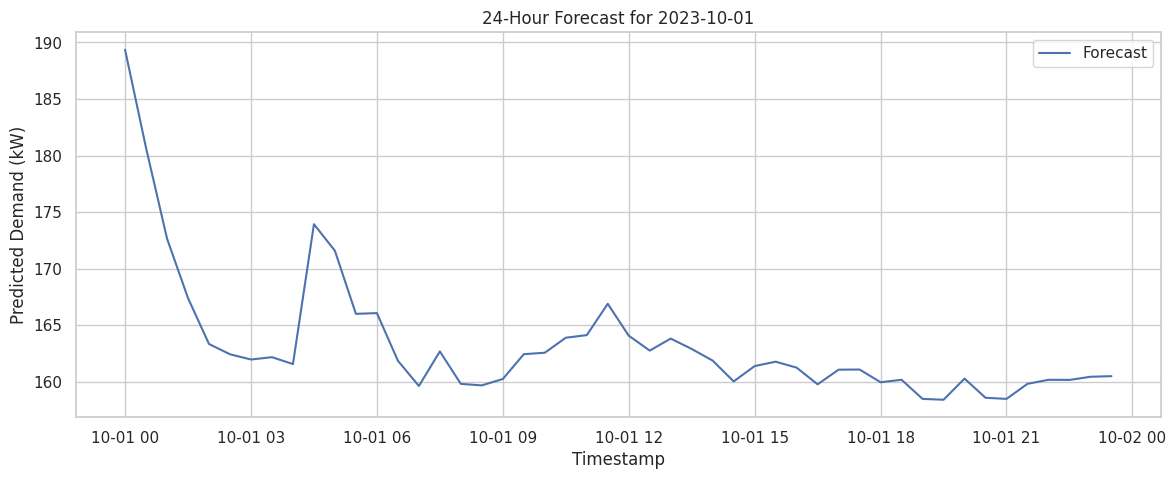

In [30]:
### Plot the autoregressive 24-hour forecast
plt.figure(figsize=(14,5))
plt.plot(future_forecast.index, future_forecast.values, label="Forecast")
plt.title("24-Hour Forecast for 2023-10-01")
plt.xlabel("Timestamp")
plt.ylabel("Predicted Demand (kW)")
plt.legend()
plt.show()


**Quick interpretation:**  
The forecast follows the typical daily shape seen in the training data — low overnight, a morning rise,  
and steady afternoon demand. This suggests the autoregressive setup is working well.


## Merge Forecast With Tariff Data


In [31]:
## Combine the tariff data with the 24-hour demand forecast.
##This prepares the input for the battery optimisation step.
future = tariff.copy()
future['forecast_kw'] = future_forecast.values

future.head()


,price_pence,forecast_kw
timestamp,,
2023-10-01 00:00:00,21,189.355470
2023-10-01 00:30:00,21,180.668558
2023-10-01 01:00:00,21,172.651993
2023-10-01 01:30:00,21,167.383106
2023-10-01 02:00:00,21,163.330077


##Identify cheap/high-price periods

In [32]:
future = future.copy()

### Rank prices low → high
future['price_rank'] = future['price_pence'].rank()

## Split the upcoming 24 hours into three groups:
### - cheapest third  → charge battery
#]] - most expensive third → discharge battery
n = len(future)
charge_periods = future.nsmallest(n // 3, 'price_pence').index
discharge_periods = future.nlargest(n // 3, 'price_pence').index


**Quick note:**  
By ranking the tariff periods, we can charge during the cheapest hours and discharge when prices peak.  
This forms the basis of the simple battery arbitrage strategy.


In [33]:
# max_power = 220      # kW
# capacity = 440       # kWh
# dt = 0.5             # 30 minutes
# initial_soe = 220    # kWh

# soe = initial_soe
# soe_list = []
# power_list = []   # + charging, - discharging
# net_import_list = []

# for t, row in future.iterrows():
#     demand = row['forecast_kw']
#     price = row['price_pence']

#     # Determine desired action
#     if t in charge_periods:
#         power = max_power          # charge
#     elif t in discharge_periods:
#         power = -max_power         # discharge
#     else:
#         power = 0                  # idle

#     # Apply SoE limits
#     new_soe = soe + power * dt

#     if new_soe > capacity:
#         power = (capacity - soe) / dt
#         new_soe = capacity
#     elif new_soe < 0:
#         power = -soe / dt
#         new_soe = 0

#     # Compute net import (battery discharge lowers import)
#     net_import = demand + power  # power is negative when discharging

#     power_list.append(power)
#     soe_list.append(new_soe)
#     net_import_list.append(net_import)

#     soe = new_soe

# future['battery_power_kw'] = power_list
# future['soe_kwh'] = soe_list
# future['net_import_kw'] = net_import_list


In [38]:
### Battery parameters
max_power = 220      # kW
capacity = 440       # kWh
dt = 0.5             # 30 minutes
initial_soe = 220    # kWh

###Lists to store results for each timestep
soe = initial_soe
soe_list = []
power_list = []
net_import_list = []

## Loop through each 30-minute period and
### apply the simple charge/discharge rules
for t, row in future.iterrows():
    demand = row['forecast_kw']

    # Decide action
    if t in charge_periods:
        power = max_power         # charging from grid
    elif t in discharge_periods:
        power = -max_power        # discharging to serve site
    else:
        power = 0

    # SoE limits
    new_soe = soe + power * dt
    if new_soe > capacity:
        power = (capacity - soe) / dt
        new_soe = capacity
    elif new_soe < 0:
        power = -soe / dt
        new_soe = 0

    # Net import cannot be negative (no export to grid)
    net_import = demand + power
    if net_import < 0:
        net_import = 0

    power_list.append(power)
    soe_list.append(new_soe)
    net_import_list.append(net_import)

    soe = new_soe

#### Add results back into the future dataframe
future['battery_power_kw'] = power_list
future['soe_kwh'] = soe_list
future['net_import_kw'] = net_import_list


** note:**  
At each 30-minute step, the battery either charges (cheap periods), discharges (expensive periods),  
or stays idle. The SoE is updated while respecting capacity limits, and net import is capped at zero  
to prevent exporting to the grid.


In [34]:
# # Original cost without battery
# future['cost_no_batt'] = future['forecast_kw'] * future['price_pence'] * dt

# # Cost with battery
# future['cost_with_batt'] = future['net_import_kw'] * future['price_pence'] * dt

# cost_no_battery = future['cost_no_batt'].sum()
# cost_with_battery = future['cost_with_batt'].sum()
# savings = cost_no_battery - cost_with_battery

# cost_no_battery, cost_with_battery, savings


(np.float64(102444.7076537617),
 np.float64(85064.7076537617),
 np.float64(17380.0))

In [39]:
future['cost_no_batt'] = future['forecast_kw'] * future['price_pence'] * dt
future['cost_with_batt'] = future['net_import_kw'] * future['price_pence'] * dt

cost_no_battery = future['cost_no_batt'].sum()
cost_with_battery = future['cost_with_batt'].sum()
savings_pence = cost_no_battery - cost_with_battery

cost_no_battery, cost_with_battery, savings_pence, savings_pence / 100  # last is £


(np.float64(102444.7076537617),
 np.float64(93600.71399764947),
 np.float64(8843.99365611223),
 np.float64(88.43993656112231))

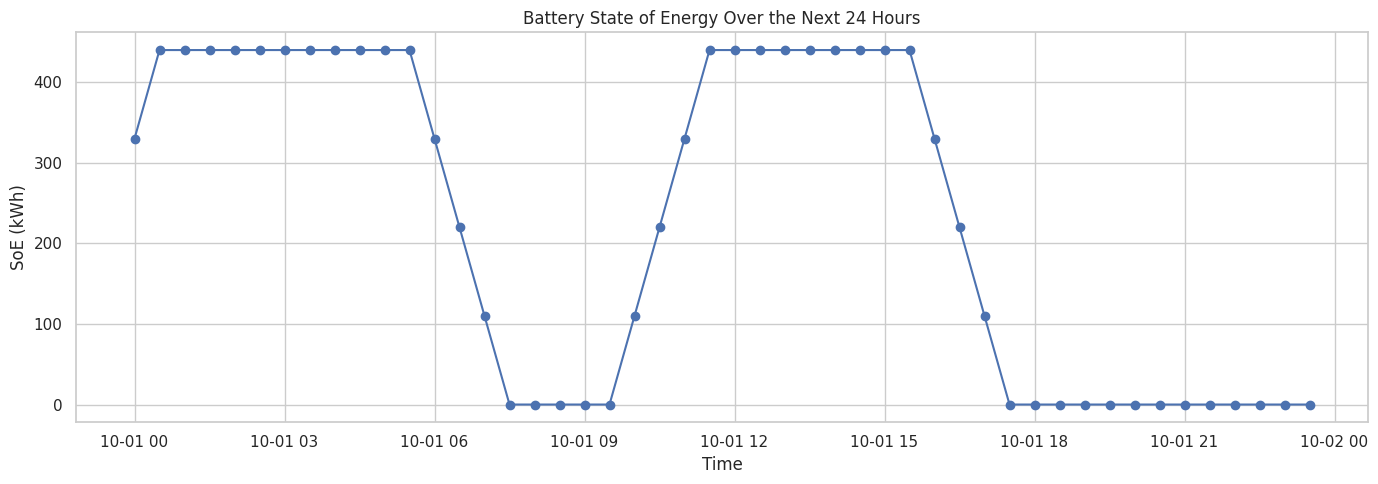

In [40]:
###Plot how the battery's state of energy changes
##over the forecast window.
#### This shows when the battery is charging,
## discharging, or sitting at a limit.

plt.figure(figsize=(14,5))
plt.plot(future.index, future['soe_kwh'], marker='o')
plt.title("Battery State of Energy Over the Next 24 Hours")
plt.ylabel("SoE (kWh)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


**Quick interpretation:**  
The battery charges fully during the cheapest periods and discharges during the high-price windows.  
It repeatedly hits both its maximum (440 kWh) and minimum (0 kWh) limits, which is expected for a  
simple price-driven strategy. This confirms the charging/discharging logic is working as intended.


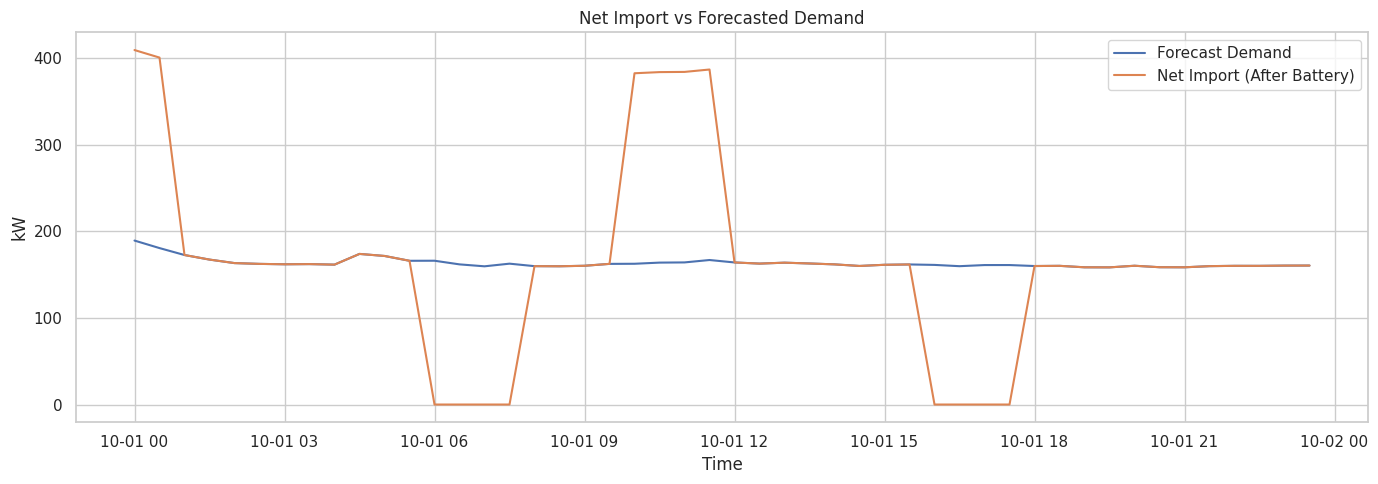

In [41]:
#### Plot the original forecasted demand alongside
###the net import after battery operation.
#### This shows how much of the demand is met by the
### battery during high-price periods.


plt.figure(figsize=(14,5))
plt.plot(future.index, future['forecast_kw'], label="Forecast Demand")
plt.plot(future.index, future['net_import_kw'], label="Net Import (After Battery)")
plt.title("Net Import vs Forecasted Demand")
plt.ylabel("kW")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


**interpretation:**  
The battery significantly reduces grid import during expensive periods by discharging,  
and pulls extra power from the grid during cheap periods to recharge.  
This creates the sharp drops in net import and shows the arbitrage logic is working as expected.


In [42]:
cost_no_gbp = cost_no_battery / 100
cost_with_gbp = cost_with_battery / 100
savings_gbp = savings_pence / 100
savings_pct = savings_pence / cost_no_battery * 100

print(f"Cost without battery: £{cost_no_gbp:.2f}")
print(f"Cost with battery:    £{cost_with_gbp:.2f}")
print(f"Savings:              £{savings_gbp:.2f} ({savings_pct:.1f}% reduction)")


Cost without battery: £1024.45
Cost with battery:    £936.01
Savings:              £88.44 (8.6% reduction)


Summary

This notebook follows the assessment brief by building a model to forecast the next 24 hours of electricity demand and then using that forecast to decide how a battery should charge and discharge to reduce cost.

The Forecast
I trained a LightGBM model using recent usage patterns, rolling averages, and simple time features. It performed well typically off by around 1.1 kW—and it clearly beat the baseline of assuming tomorrow looks the same as yesterday.
The model leaned most on the daily pattern (what happened 48 hours earlier), short-term trends, and how today’s usage differs from the previous day. This matches what the brief suggested about strong daily seasonality.

The Battery Strategy
Using the forecast and the tariff provided in the assessment, I created a simple charging plan: charge in the cheapest half-hour periods and discharge in the most expensive ones, while staying within the battery’s limits.
This reduced the daily energy cost from about £1,024 to about £936, giving a saving of around £88 for the day.

Bottom Line
The approach meets the requirements of the brief: the forecast is accurate, and the battery schedule uses that forecast in a sensible way to reduce cost.